# Import Libraries

In [1]:

import os
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip
import torch
from code.classifier import ViTPneumoniaClassifier, Config
from code.plot_random_image import plot_random_image_from_loader
from code.classify_random_images import plot_random_images_with_labels
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from code.classifier import PneumoniaClassifier




C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load the TensorBoard
%reload_ext tensorboard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Enable CUDA Launch Blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Set float32 matrix multiplication precision to 'medium' to utilize Tensor Cores
torch.set_float32_matmul_precision('medium')
torch.serialization.add_safe_globals([Compose, Resize, set, Config, InterpolationMode, ToTensor, Normalize, RandomHorizontalFlip])

# Check GPU Availability

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Sat Dec  7 21:35:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   44C    P8             13W /  285W |    4927MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Setup Model

In [5]:
config = Config(
    backbone_name="google/vit-base-patch16-224",
    transfer_learning=True,
    learning_rate=1e-5,
    batch_size=32,
    max_epochs=100,
    weight_decay=1e-5,
    dropout=0.3,
    num_workers=16,
    model_name="Vit-unfreeze",
    version="001",
    optimizer_name = "adam",
    use_class_weights=True,
    image_res=224,
    patience = 10,
    image_type=3
)
model = ViTPneumoniaClassifier(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)




Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Plot random images from all datasets

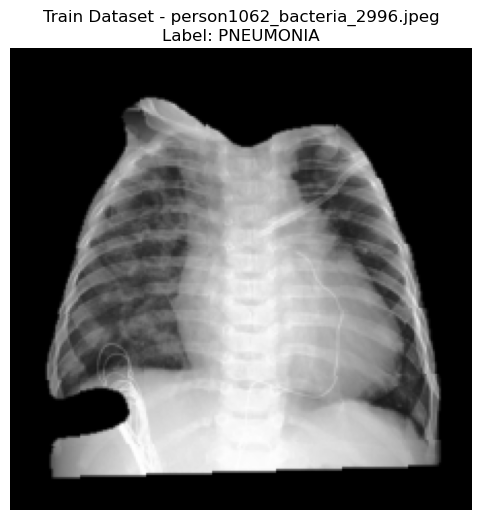

In [6]:
plot_random_image_from_loader(model.train_loader.dataset, "Train Dataset", normalize=False)

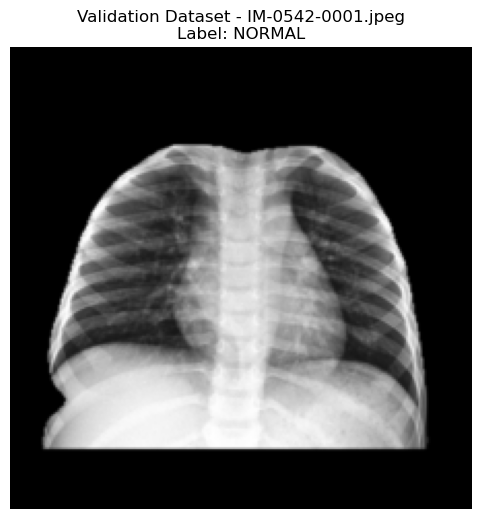

In [8]:
plot_random_image_from_loader(model.val_loader.dataset, "Validation Dataset", normalize=False)

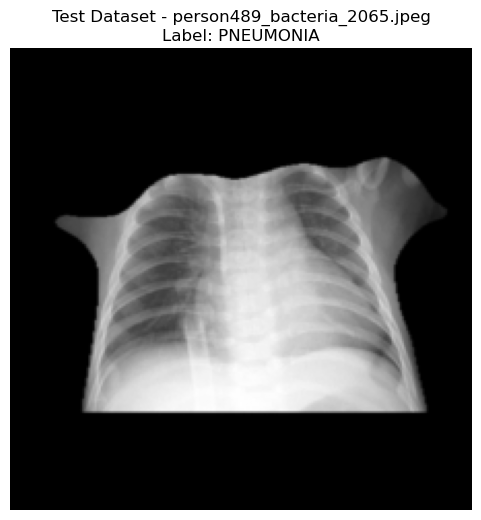

In [9]:
plot_random_image_from_loader(model.test_loader.dataset, "Test Dataset", normalize=False)

# Train Model

In [10]:

# Train Model
model.train_model()
torch.save({
    "state_dict": model.state_dict(),
    "config": config
}, f"../models/{config.model_name}_final.pt")

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\aszab\Documents\Studium\Modules\ComputerScienceProject\MedicalImaging\pneumonia_detection\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name              | Type                      | Params | Mode 
------------------------------------------------------------------------
0 | accuracy          | BinaryAccuracy            | 0      | train
1 | precision         | BinaryPrecision           | 0      | train
2 | recall            | BinaryRecall              | 0      | train
3 | f1                | BinaryF1Score             | 0      | train
4 | specificity       | BinarySpecificity       

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.58it/s]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.649]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 129/129 [01:13<00:00,  1.75it/s, v_num=0, train_loss_step=0.649, val_acc_epoch=0.462, val_precision_epoch=0.766, val_recall_epoch=0.377, val_f1_epoch=0.506, val_specificity_epoch=0.688]

C:\Users\aszab\miniconda3\envs\pneumonia_detection\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Metric val_loss improved. New best score: 0.671


Epoch 1: 100%|██████████| 129/129 [00:59<00:00,  2.16it/s, v_num=0, train_loss_step=0.704, val_acc_epoch=0.462, val_precision_epoch=0.766, val_recall_epoch=0.377, val_f1_epoch=0.506, val_specificity_epoch=0.688]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 129/129 [01:13<00:00,  1.75it/s, v_num=0, train_loss_step=0.704, val_acc_epoch=0.608, val_precision_epoch=0.803, val_recall_epoch=0.612, val_f1_epoch=0.695, val_specificity_epoch=0.596]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.617


Epoch 2: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.492, val_acc_epoch=0.608, val_precision_epoch=0.803, val_recall_epoch=0.612, val_f1_epoch=0.695, val_specificity_epoch=0.596]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.492, val_acc_epoch=0.692, val_precision_epoch=0.847, val_recall_epoch=0.705, val_f1_epoch=0.770, val_specificity_epoch=0.655]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.587


Epoch 3: 100%|██████████| 129/129 [00:59<00:00,  2.15it/s, v_num=0, train_loss_step=0.599, val_acc_epoch=0.692, val_precision_epoch=0.847, val_recall_epoch=0.705, val_f1_epoch=0.770, val_specificity_epoch=0.655]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 129/129 [01:14<00:00,  1.74it/s, v_num=0, train_loss_step=0.599, val_acc_epoch=0.743, val_precision_epoch=0.888, val_recall_epoch=0.741, val_f1_epoch=0.808, val_specificity_epoch=0.748]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.559


Epoch 4: 100%|██████████| 129/129 [00:59<00:00,  2.16it/s, v_num=0, train_loss_step=0.534, val_acc_epoch=0.743, val_precision_epoch=0.888, val_recall_epoch=0.741, val_f1_epoch=0.808, val_specificity_epoch=0.748]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 129/129 [01:13<00:00,  1.75it/s, v_num=0, train_loss_step=0.534, val_acc_epoch=0.798, val_precision_epoch=0.904, val_recall_epoch=0.808, val_f1_epoch=0.854, val_specificity_epoch=0.770]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.542


Epoch 5: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.493, val_acc_epoch=0.798, val_precision_epoch=0.904, val_recall_epoch=0.808, val_f1_epoch=0.854, val_specificity_epoch=0.770]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.493, val_acc_epoch=0.806, val_precision_epoch=0.936, val_recall_epoch=0.788, val_f1_epoch=0.855, val_specificity_epoch=0.854]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.514


Epoch 6: 100%|██████████| 129/129 [00:59<00:00,  2.16it/s, v_num=0, train_loss_step=0.387, val_acc_epoch=0.806, val_precision_epoch=0.936, val_recall_epoch=0.788, val_f1_epoch=0.855, val_specificity_epoch=0.854]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.387, val_acc_epoch=0.821, val_precision_epoch=0.941, val_recall_epoch=0.805, val_f1_epoch=0.868, val_specificity_epoch=0.863]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.493


Epoch 7: 100%|██████████| 129/129 [00:59<00:00,  2.16it/s, v_num=0, train_loss_step=0.466, val_acc_epoch=0.821, val_precision_epoch=0.941, val_recall_epoch=0.805, val_f1_epoch=0.868, val_specificity_epoch=0.863]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 129/129 [01:13<00:00,  1.75it/s, v_num=0, train_loss_step=0.466, val_acc_epoch=0.827, val_precision_epoch=0.940, val_recall_epoch=0.816, val_f1_epoch=0.873, val_specificity_epoch=0.859]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.474


Epoch 8: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.548, val_acc_epoch=0.827, val_precision_epoch=0.940, val_recall_epoch=0.816, val_f1_epoch=0.873, val_specificity_epoch=0.859]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.548, val_acc_epoch=0.836, val_precision_epoch=0.950, val_recall_epoch=0.818, val_f1_epoch=0.879, val_specificity_epoch=0.885]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.457


Epoch 9: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.348, val_acc_epoch=0.836, val_precision_epoch=0.950, val_recall_epoch=0.818, val_f1_epoch=0.879, val_specificity_epoch=0.885]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 129/129 [01:11<00:00,  1.80it/s, v_num=0, train_loss_step=0.348, val_acc_epoch=0.843, val_precision_epoch=0.949, val_recall_epoch=0.830, val_f1_epoch=0.885, val_specificity_epoch=0.880]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.447


Epoch 10: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.332, val_acc_epoch=0.843, val_precision_epoch=0.949, val_recall_epoch=0.830, val_f1_epoch=0.885, val_specificity_epoch=0.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.332, val_acc_epoch=0.838, val_precision_epoch=0.954, val_recall_epoch=0.817, val_f1_epoch=0.880, val_specificity_epoch=0.894]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.431


Epoch 11: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.234, val_acc_epoch=0.838, val_precision_epoch=0.954, val_recall_epoch=0.817, val_f1_epoch=0.880, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.234, val_acc_epoch=0.845, val_precision_epoch=0.956, val_recall_epoch=0.826, val_f1_epoch=0.886, val_specificity_epoch=0.898]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.419


Epoch 12: 100%|██████████| 129/129 [00:57<00:00,  2.23it/s, v_num=0, train_loss_step=0.402, val_acc_epoch=0.845, val_precision_epoch=0.956, val_recall_epoch=0.826, val_f1_epoch=0.886, val_specificity_epoch=0.898]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 129/129 [01:11<00:00,  1.81it/s, v_num=0, train_loss_step=0.402, val_acc_epoch=0.848, val_precision_epoch=0.952, val_recall_epoch=0.833, val_f1_epoch=0.889, val_specificity_epoch=0.888]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.411


Epoch 13: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.405, val_acc_epoch=0.848, val_precision_epoch=0.952, val_recall_epoch=0.833, val_f1_epoch=0.889, val_specificity_epoch=0.888]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.405, val_acc_epoch=0.850, val_precision_epoch=0.958, val_recall_epoch=0.830, val_f1_epoch=0.889, val_specificity_epoch=0.903]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.398


Epoch 14: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.294, val_acc_epoch=0.850, val_precision_epoch=0.958, val_recall_epoch=0.830, val_f1_epoch=0.889, val_specificity_epoch=0.903]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.349, val_acc_epoch=0.859, val_precision_epoch=0.956, val_recall_epoch=0.846, val_f1_epoch=0.897, val_specificity_epoch=0.894]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.349, val_acc_epoch=0.851, val_precision_epoch=0.960, val_recall_epoch=0.831, val_f1_epoch=0.891, val_specificity_epoch=0.906]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.386


Epoch 16: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.278, val_acc_epoch=0.851, val_precision_epoch=0.960, val_recall_epoch=0.831, val_f1_epoch=0.891, val_specificity_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.278, val_acc_epoch=0.855, val_precision_epoch=0.958, val_recall_epoch=0.838, val_f1_epoch=0.894, val_specificity_epoch=0.900]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.384


Epoch 17: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.183, val_acc_epoch=0.855, val_precision_epoch=0.958, val_recall_epoch=0.838, val_f1_epoch=0.894, val_specificity_epoch=0.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.183, val_acc_epoch=0.854, val_precision_epoch=0.962, val_recall_epoch=0.833, val_f1_epoch=0.893, val_specificity_epoch=0.912]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.375


Epoch 18: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.218, val_acc_epoch=0.854, val_precision_epoch=0.962, val_recall_epoch=0.833, val_f1_epoch=0.893, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.218, val_acc_epoch=0.862, val_precision_epoch=0.964, val_recall_epoch=0.843, val_f1_epoch=0.899, val_specificity_epoch=0.915]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.363


Epoch 19: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.913, val_acc_epoch=0.862, val_precision_epoch=0.964, val_recall_epoch=0.843, val_f1_epoch=0.899, val_specificity_epoch=0.915]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.913, val_acc_epoch=0.864, val_precision_epoch=0.961, val_recall_epoch=0.848, val_f1_epoch=0.901, val_specificity_epoch=0.907]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.362


Epoch 20: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.355, val_acc_epoch=0.864, val_precision_epoch=0.961, val_recall_epoch=0.848, val_f1_epoch=0.901, val_specificity_epoch=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.355, val_acc_epoch=0.865, val_precision_epoch=0.965, val_recall_epoch=0.846, val_f1_epoch=0.902, val_specificity_epoch=0.918]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.357


Epoch 21: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.305, val_acc_epoch=0.865, val_precision_epoch=0.965, val_recall_epoch=0.846, val_f1_epoch=0.902, val_specificity_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.305, val_acc_epoch=0.867, val_precision_epoch=0.963, val_recall_epoch=0.850, val_f1_epoch=0.903, val_specificity_epoch=0.912]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.349


Epoch 22: 100%|██████████| 129/129 [00:59<00:00,  2.15it/s, v_num=0, train_loss_step=0.273, val_acc_epoch=0.867, val_precision_epoch=0.963, val_recall_epoch=0.850, val_f1_epoch=0.903, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████| 129/129 [01:13<00:00,  1.74it/s, v_num=0, train_loss_step=0.273, val_acc_epoch=0.861, val_precision_epoch=0.961, val_recall_epoch=0.844, val_f1_epoch=0.899, val_specificity_epoch=0.908]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.348


Epoch 23: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.380, val_acc_epoch=0.861, val_precision_epoch=0.961, val_recall_epoch=0.844, val_f1_epoch=0.899, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.380, val_acc_epoch=0.865, val_precision_epoch=0.960, val_recall_epoch=0.850, val_f1_epoch=0.902, val_specificity_epoch=0.906]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.344


Epoch 24: 100%|██████████| 129/129 [00:59<00:00,  2.19it/s, v_num=0, train_loss_step=0.345, val_acc_epoch=0.865, val_precision_epoch=0.960, val_recall_epoch=0.850, val_f1_epoch=0.902, val_specificity_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.345, val_acc_epoch=0.865, val_precision_epoch=0.962, val_recall_epoch=0.849, val_f1_epoch=0.902, val_specificity_epoch=0.909]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.336


Epoch 25: 100%|██████████| 129/129 [00:59<00:00,  2.19it/s, v_num=0, train_loss_step=0.612, val_acc_epoch=0.865, val_precision_epoch=0.962, val_recall_epoch=0.849, val_f1_epoch=0.902, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.612, val_acc_epoch=0.867, val_precision_epoch=0.961, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.908]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.331


Epoch 26: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.268, val_acc_epoch=0.867, val_precision_epoch=0.961, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.268, val_acc_epoch=0.867, val_precision_epoch=0.962, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.909]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.330


Epoch 27: 100%|██████████| 129/129 [00:59<00:00,  2.17it/s, v_num=0, train_loss_step=0.191, val_acc_epoch=0.867, val_precision_epoch=0.962, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.909]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.191, val_acc_epoch=0.872, val_precision_epoch=0.962, val_recall_epoch=0.860, val_f1_epoch=0.908, val_specificity_epoch=0.907]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.326


Epoch 28: 100%|██████████| 129/129 [00:57<00:00,  2.25it/s, v_num=0, train_loss_step=0.115, val_acc_epoch=0.872, val_precision_epoch=0.962, val_recall_epoch=0.860, val_f1_epoch=0.908, val_specificity_epoch=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████| 129/129 [01:11<00:00,  1.81it/s, v_num=0, train_loss_step=0.115, val_acc_epoch=0.867, val_precision_epoch=0.961, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.908]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.323


Epoch 29: 100%|██████████| 129/129 [00:57<00:00,  2.26it/s, v_num=0, train_loss_step=0.170, val_acc_epoch=0.867, val_precision_epoch=0.961, val_recall_epoch=0.852, val_f1_epoch=0.903, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████| 129/129 [01:10<00:00,  1.82it/s, v_num=0, train_loss_step=0.170, val_acc_epoch=0.870, val_precision_epoch=0.963, val_recall_epoch=0.854, val_f1_epoch=0.905, val_specificity_epoch=0.911]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.318


Epoch 30: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.215, val_acc_epoch=0.870, val_precision_epoch=0.963, val_recall_epoch=0.854, val_f1_epoch=0.905, val_specificity_epoch=0.911]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.136, val_acc_epoch=0.872, val_precision_epoch=0.961, val_recall_epoch=0.860, val_f1_epoch=0.908, val_specificity_epoch=0.906]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.136, val_acc_epoch=0.871, val_precision_epoch=0.963, val_recall_epoch=0.856, val_f1_epoch=0.906, val_specificity_epoch=0.912]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.315


Epoch 32: 100%|██████████| 129/129 [00:57<00:00,  2.26it/s, v_num=0, train_loss_step=0.182, val_acc_epoch=0.871, val_precision_epoch=0.963, val_recall_epoch=0.856, val_f1_epoch=0.906, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████| 129/129 [01:10<00:00,  1.82it/s, v_num=0, train_loss_step=0.182, val_acc_epoch=0.874, val_precision_epoch=0.964, val_recall_epoch=0.859, val_f1_epoch=0.908, val_specificity_epoch=0.912]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.309


Epoch 33: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.0922, val_acc_epoch=0.874, val_precision_epoch=0.964, val_recall_epoch=0.859, val_f1_epoch=0.908, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.163, val_acc_epoch=0.877, val_precision_epoch=0.963, val_recall_epoch=0.865, val_f1_epoch=0.911, val_specificity_epoch=0.911]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.163, val_acc_epoch=0.874, val_precision_epoch=0.962, val_recall_epoch=0.861, val_f1_epoch=0.909, val_specificity_epoch=0.908]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.306


Epoch 35: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.249, val_acc_epoch=0.874, val_precision_epoch=0.962, val_recall_epoch=0.861, val_f1_epoch=0.909, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.249, val_acc_epoch=0.876, val_precision_epoch=0.963, val_recall_epoch=0.863, val_f1_epoch=0.910, val_specificity_epoch=0.910]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.305


Epoch 36: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.600, val_acc_epoch=0.876, val_precision_epoch=0.963, val_recall_epoch=0.863, val_f1_epoch=0.910, val_specificity_epoch=0.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.600, val_acc_epoch=0.879, val_precision_epoch=0.962, val_recall_epoch=0.868, val_f1_epoch=0.913, val_specificity_epoch=0.908]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.303


Epoch 37: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.186, val_acc_epoch=0.879, val_precision_epoch=0.962, val_recall_epoch=0.868, val_f1_epoch=0.913, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.045, val_acc_epoch=0.876, val_precision_epoch=0.963, val_recall_epoch=0.864, val_f1_epoch=0.911, val_specificity_epoch=0.911]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.045, val_acc_epoch=0.879, val_precision_epoch=0.964, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.912]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.298


Epoch 39: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.0929, val_acc_epoch=0.879, val_precision_epoch=0.964, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.0929, val_acc_epoch=0.876, val_precision_epoch=0.963, val_recall_epoch=0.863, val_f1_epoch=0.910, val_specificity_epoch=0.910]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.297


Epoch 40: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.168, val_acc_epoch=0.876, val_precision_epoch=0.963, val_recall_epoch=0.863, val_f1_epoch=0.910, val_specificity_epoch=0.910]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.168, val_acc_epoch=0.879, val_precision_epoch=0.967, val_recall_epoch=0.864, val_f1_epoch=0.912, val_specificity_epoch=0.920]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.296


Epoch 41: 100%|██████████| 129/129 [00:57<00:00,  2.25it/s, v_num=0, train_loss_step=0.206, val_acc_epoch=0.879, val_precision_epoch=0.967, val_recall_epoch=0.864, val_f1_epoch=0.912, val_specificity_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████| 129/129 [01:10<00:00,  1.83it/s, v_num=0, train_loss_step=0.206, val_acc_epoch=0.880, val_precision_epoch=0.967, val_recall_epoch=0.865, val_f1_epoch=0.913, val_specificity_epoch=0.920]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.291


Epoch 42: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.220, val_acc_epoch=0.880, val_precision_epoch=0.967, val_recall_epoch=0.865, val_f1_epoch=0.913, val_specificity_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.187, val_acc_epoch=0.879, val_precision_epoch=0.962, val_recall_epoch=0.868, val_f1_epoch=0.913, val_specificity_epoch=0.908]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.187, val_acc_epoch=0.879, val_precision_epoch=0.966, val_recall_epoch=0.866, val_f1_epoch=0.913, val_specificity_epoch=0.917]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.290


Epoch 44: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.565, val_acc_epoch=0.879, val_precision_epoch=0.966, val_recall_epoch=0.866, val_f1_epoch=0.913, val_specificity_epoch=0.917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.565, val_acc_epoch=0.885, val_precision_epoch=0.965, val_recall_epoch=0.874, val_f1_epoch=0.917, val_specificity_epoch=0.914]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.288


Epoch 45: 100%|██████████| 129/129 [00:59<00:00,  2.19it/s, v_num=0, train_loss_step=0.0898, val_acc_epoch=0.885, val_precision_epoch=0.965, val_recall_epoch=0.874, val_f1_epoch=0.917, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████| 129/129 [01:13<00:00,  1.77it/s, v_num=0, train_loss_step=0.0898, val_acc_epoch=0.878, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.911]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.287


Epoch 46: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.396, val_acc_epoch=0.878, val_precision_epoch=0.963, val_recall_epoch=0.866, val_f1_epoch=0.912, val_specificity_epoch=0.911]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.0858, val_acc_epoch=0.885, val_precision_epoch=0.965, val_recall_epoch=0.874, val_f1_epoch=0.917, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.683, val_acc_epoch=0.886, val_precision_epoch=0.964, val_recall_epoch=0.876, val_f1_epoch=0.918, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.683, val_acc_epoch=0.883, val_precision_epoch=0.964, val_recall_epoch=0.873, val_f1_epoch=0.916, val_specificity_epoch=0.912]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.282


Epoch 49: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.272, val_acc_epoch=0.883, val_precision_epoch=0.964, val_recall_epoch=0.873, val_f1_epoch=0.916, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.0558, val_acc_epoch=0.887, val_precision_epoch=0.965, val_recall_epoch=0.877, val_f1_epoch=0.919, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.338, val_acc_epoch=0.885, val_precision_epoch=0.965, val_recall_epoch=0.874, val_f1_epoch=0.917, val_specificity_epoch=0.915]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.338, val_acc_epoch=0.887, val_precision_epoch=0.966, val_recall_epoch=0.875, val_f1_epoch=0.919, val_specificity_epoch=0.917]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.279


Epoch 52: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.112, val_acc_epoch=0.887, val_precision_epoch=0.966, val_recall_epoch=0.875, val_f1_epoch=0.919, val_specificity_epoch=0.917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, v_num=0, train_loss_step=0.112, val_acc_epoch=0.887, val_precision_epoch=0.966, val_recall_epoch=0.875, val_f1_epoch=0.919, val_specificity_epoch=0.917]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.279


Epoch 53: 100%|██████████| 129/129 [00:56<00:00,  2.26it/s, v_num=0, train_loss_step=0.173, val_acc_epoch=0.887, val_precision_epoch=0.966, val_recall_epoch=0.875, val_f1_epoch=0.919, val_specificity_epoch=0.917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.294, val_acc_epoch=0.893, val_precision_epoch=0.967, val_recall_epoch=0.884, val_f1_epoch=0.924, val_specificity_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.294, val_acc_epoch=0.885, val_precision_epoch=0.966, val_recall_epoch=0.873, val_f1_epoch=0.918, val_specificity_epoch=0.918]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.276


Epoch 55: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.505, val_acc_epoch=0.885, val_precision_epoch=0.966, val_recall_epoch=0.873, val_f1_epoch=0.918, val_specificity_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.511, val_acc_epoch=0.888, val_precision_epoch=0.966, val_recall_epoch=0.877, val_f1_epoch=0.920, val_specificity_epoch=0.916]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.511, val_acc_epoch=0.892, val_precision_epoch=0.967, val_recall_epoch=0.882, val_f1_epoch=0.923, val_specificity_epoch=0.920]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.273


Epoch 57: 100%|██████████| 129/129 [00:59<00:00,  2.19it/s, v_num=0, train_loss_step=0.174, val_acc_epoch=0.892, val_precision_epoch=0.967, val_recall_epoch=0.882, val_f1_epoch=0.923, val_specificity_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.110, val_acc_epoch=0.892, val_precision_epoch=0.964, val_recall_epoch=0.884, val_f1_epoch=0.922, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.273, val_acc_epoch=0.889, val_precision_epoch=0.967, val_recall_epoch=0.878, val_f1_epoch=0.920, val_specificity_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.273, val_acc_epoch=0.891, val_precision_epoch=0.966, val_recall_epoch=0.882, val_f1_epoch=0.922, val_specificity_epoch=0.915]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.273


Epoch 60: 100%|██████████| 129/129 [00:57<00:00,  2.26it/s, v_num=0, train_loss_step=0.438, val_acc_epoch=0.891, val_precision_epoch=0.966, val_recall_epoch=0.882, val_f1_epoch=0.922, val_specificity_epoch=0.915]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████| 129/129 [01:10<00:00,  1.83it/s, v_num=0, train_loss_step=0.438, val_acc_epoch=0.886, val_precision_epoch=0.964, val_recall_epoch=0.876, val_f1_epoch=0.918, val_specificity_epoch=0.912]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.271


Epoch 61: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.318, val_acc_epoch=0.886, val_precision_epoch=0.964, val_recall_epoch=0.876, val_f1_epoch=0.918, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.318, val_acc_epoch=0.891, val_precision_epoch=0.964, val_recall_epoch=0.884, val_f1_epoch=0.922, val_specificity_epoch=0.911]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.271


Epoch 62: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.116, val_acc_epoch=0.891, val_precision_epoch=0.964, val_recall_epoch=0.884, val_f1_epoch=0.922, val_specificity_epoch=0.911]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|██████████| 129/129 [01:12<00:00,  1.77it/s, v_num=0, train_loss_step=0.116, val_acc_epoch=0.889, val_precision_epoch=0.965, val_recall_epoch=0.881, val_f1_epoch=0.921, val_specificity_epoch=0.914]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.269


Epoch 63: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.460, val_acc_epoch=0.889, val_precision_epoch=0.965, val_recall_epoch=0.881, val_f1_epoch=0.921, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.110, val_acc_epoch=0.890, val_precision_epoch=0.963, val_recall_epoch=0.883, val_f1_epoch=0.921, val_specificity_epoch=0.909] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.291, val_acc_epoch=0.893, val_precision_epoch=0.967, val_recall_epoch=0.884, val_f1_epoch=0.923, val_specificity_epoch=0.919]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 66: 100%|██████████| 129/129 [00:58<00:00,  2.20it/s, v_num=0, train_loss_step=0.259, val_acc_epoch=0.893, val_precision_epoch=0.969, val_recall_epoch=0.882, val_f1_epoch=0.923, val_specificity_epoch=0.923]
Validatio

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.265


Epoch 67: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=2.060, val_acc_epoch=0.894, val_precision_epoch=0.967, val_recall_epoch=0.885, val_f1_epoch=0.924, val_specificity_epoch=0.917]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=2.060, val_acc_epoch=0.895, val_precision_epoch=0.965, val_recall_epoch=0.888, val_f1_epoch=0.925, val_specificity_epoch=0.913]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.264


Epoch 68: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.122, val_acc_epoch=0.895, val_precision_epoch=0.965, val_recall_epoch=0.888, val_f1_epoch=0.925, val_specificity_epoch=0.913]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████| 129/129 [00:58<00:00,  2.22it/s, v_num=0, train_loss_step=0.438, val_acc_epoch=0.894, val_precision_epoch=0.964, val_recall_epoch=0.887, val_f1_epoch=0.924, val_specificity_epoch=0.912]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████| 129/129 [01:12<00:00,  1.79it/s, v_num=0, train_loss_step=0.438, val_acc_epoch=0.892, val_precision_epoch=0.967, val_recall_epoch=0.882, val_f1_epoch=0.923, val_specificity_epoch=0.920]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.262


Epoch 70: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.300, val_acc_epoch=0.892, val_precision_epoch=0.967, val_recall_epoch=0.882, val_f1_epoch=0.923, val_specificity_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.0153, val_acc_epoch=0.894, val_precision_epoch=0.966, val_recall_epoch=0.885, val_f1_epoch=0.924, val_specificity_epoch=0.916]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.141, val_acc_epoch=0.897, val_precision_epoch=0.965, val_recall_epoch=0.890, val_f1_epoch=0.926, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 73: 100%|██████████| 129/129 [00:59<00:00,  2.16it/s, v_num=0, train_loss_step=0.146, val_acc_epoch=0.895, val_precision_epoch=0.968, val_recall_epoch=0.885, val_f1_epoch=0.925, val_specificity_epoch=0.920]
Validatio

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.258


Epoch 74: 100%|██████████| 129/129 [00:58<00:00,  2.21it/s, v_num=0, train_loss_step=0.121, val_acc_epoch=0.895, val_precision_epoch=0.968, val_recall_epoch=0.886, val_f1_epoch=0.925, val_specificity_epoch=0.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 75: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.107, val_acc_epoch=0.897, val_precision_epoch=0.966, val_recall_epoch=0.890, val_f1_epoch=0.926, val_specificity_epoch=0.914]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████| 129/129 [00:58<00:00,  2.19it/s, v_num=0, train_loss_step=0.0609, val_acc_epoch=0.899, val_precision_epoch=0.967, val_recall_epoch=0.892, val_f1_epoch=0.928, val_specificity_epoch=0.918]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|██████████| 129/129 [00:59<00:00,  2.18it/s, v_num=0, train_loss_step=0.068, val_acc_epoch=0.898, val_precision_epoch=0.967, val_recall_epoch=0.890, val_f1_epoch=0.927, val_specificity_epoch=0.918]
Validatio

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.258. Signaling Trainer to stop.


Epoch 83: 100%|██████████| 129/129 [01:12<00:00,  1.78it/s, v_num=0, train_loss_step=0.221, val_acc_epoch=0.893, val_precision_epoch=0.966, val_recall_epoch=0.885, val_f1_epoch=0.924, val_specificity_epoch=0.916]


# Load Model

In [7]:

checkpoint = torch.load(f"../models/{config.model_name}_final.pt")
loaded_config = checkpoint["config"]
model = ViTPneumoniaClassifier(loaded_config)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
model = model.to(device)

C:\Users\aszab\AppData\Local\Temp\ipykernel_10980\3319896268.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../models/{config.model_name}_fina

# Test Model

In [12]:
# Run testing
print("Testing the model...")
checkpoint_path = f"../checkpoints/{config.model_name}.ckpt"
test_metadata = model.test_model(checkpoint_path)  # Ensure this uses the correct test_loader

Testing the model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 28/28 [00:12<00:00,  2.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8987485766410828
      test_f1_epoch         0.9265069961547852
  test_precision_epoch      0.9842105507850647
    test_recall_epoch       0.8751950263977051
 test_specificity_epoch     0.9621848464012146
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Plot Confusion Matrix

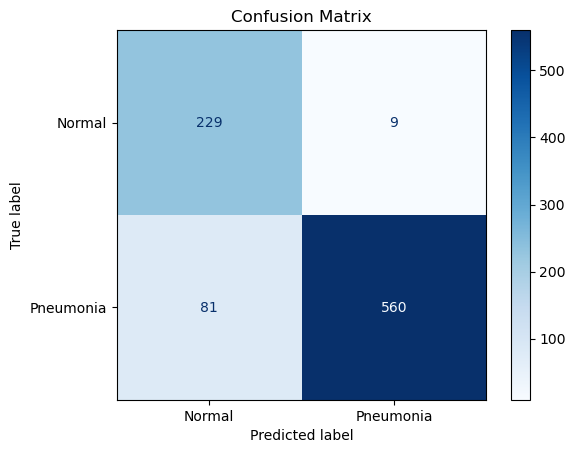

In [13]:
def plot_confusion_matrix(model, dataloader, class_names):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()  # Move data to GPU if available
            labels = labels.cuda()
            preds = torch.argmax(model(data), dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call this after training/testing
plot_confusion_matrix(model, model.test_loader, class_names=["Normal", "Pneumonia"])

# Plot ROC/AUC Score

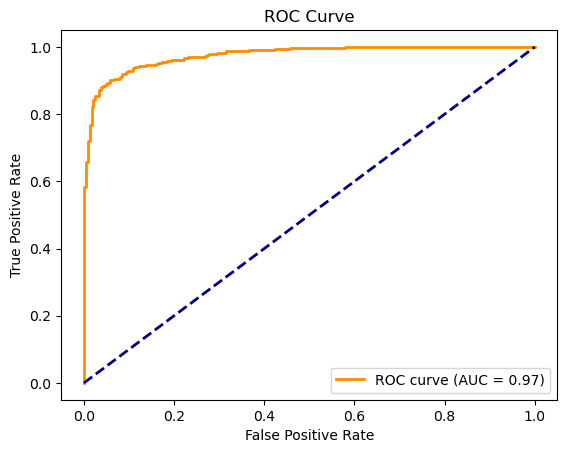

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_auc(model, dataloader):
    all_preds = []
    all_labels = []

    # Get predictions and true labels
    model.eval()
    with torch.no_grad():
        for data, labels, _ in dataloader:
            data = data.cuda()
            labels = labels.cuda()
            preds = model(data)
            probs = torch.softmax(preds, dim=1)[:, 1]  # Probabilities for class 1
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(model, model.test_loader)

# Plot Gradcam

In [15]:
for param in model.feature_extractor.parameters():
    param.requires_grad = True

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

def reshape_transform(tensor):
    activations = tensor[:, 1:, :]
    activations = activations.reshape(activations.shape[0], int(np.sqrt(activations.shape[1])), -1, activations.shape[2])
    return activations.permute(0, 3, 1, 2)

# Use the last layer of the encoder as the target
target_layer = model.feature_extractor.vit.encoder.layer[-1]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform)

# Pass input image tensor
input_tensor = inputs  # Your input tensor
grayscale_cam = cam(input_tensor=input_tensor)

# Visualize Grad-CAM
heatmap = show_cam_on_image(rgb_image, grayscale_cam[0], use_rgb=True)



NameError: name 'inputs' is not defined

# Evaluate Metrics in Tensorboard

In [16]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify the log directory
log_dir = f"tb_logs/{config.model_name}"

# Start TensorBoard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Classify random images

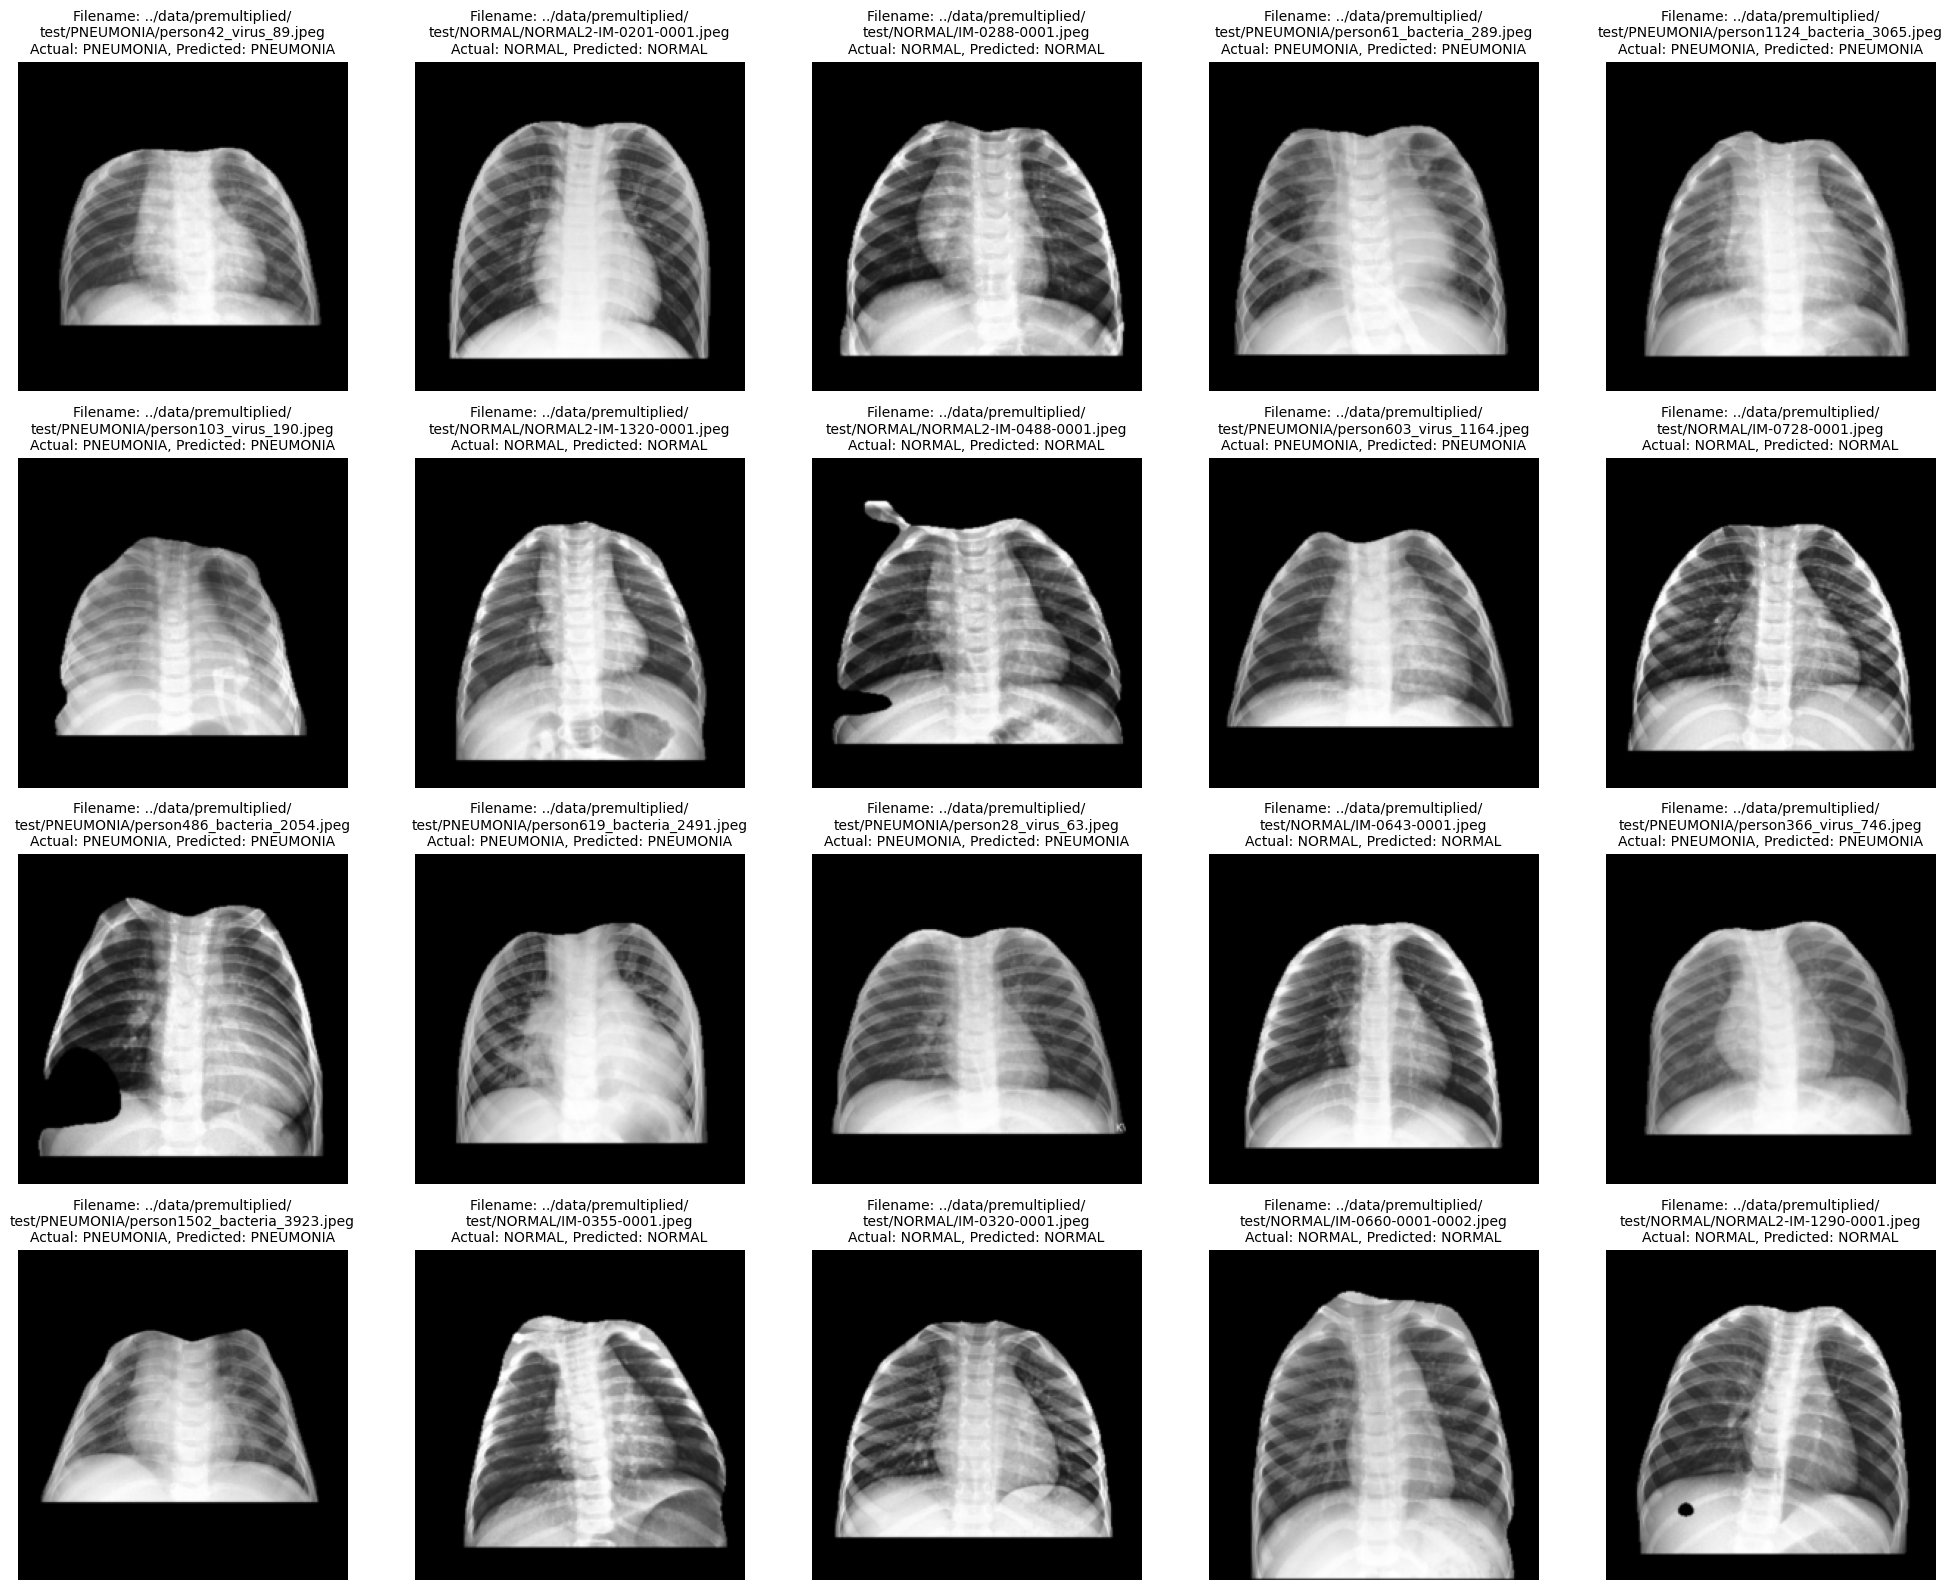

In [8]:
plot_random_images_with_labels(model, model.test_loader, num_images=20)